In [1]:
import numpy as np

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
import LearningCutsUtils.Utils as LCU
importlib.reload(LearningCutsUtils.Utils)

<module 'LearningCutsUtils.Utils' from '/home/mhance/NN-For-Cuts/LearningCutsUtils/Utils.py'>

In [3]:
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars

In [4]:
N=20000 # number of points
m=10 # dimensions

In [5]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

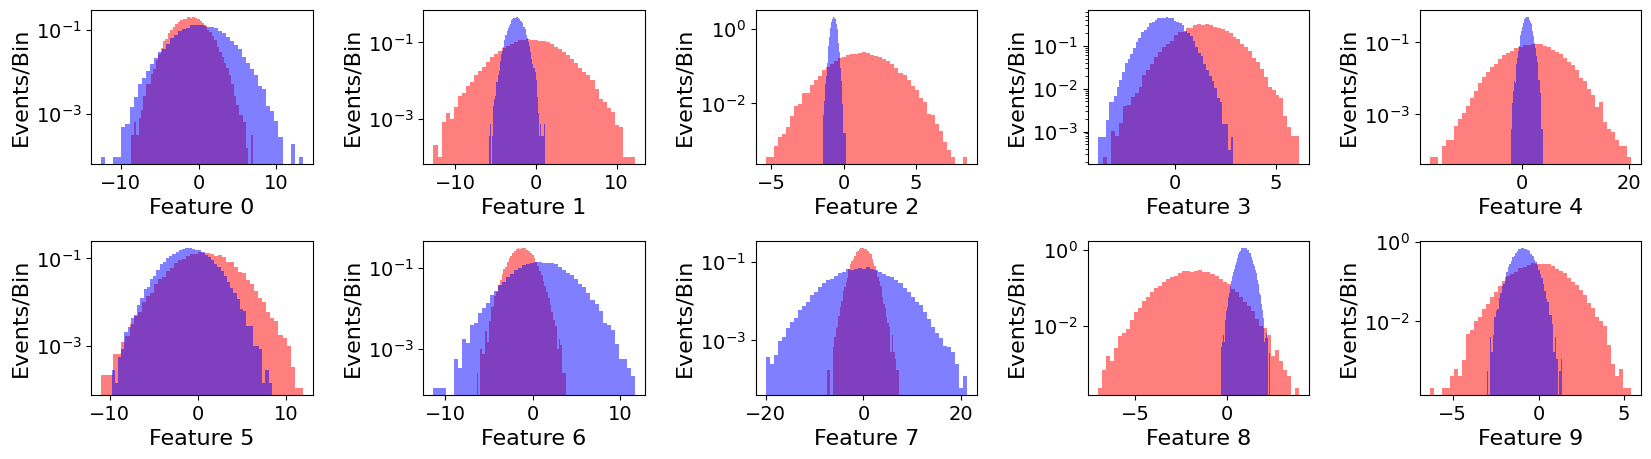

In [6]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [8]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [9]:
gt=1.
lt=-1.
cuts_gt_lt = []
if m==10:
# default for a long time
#    cuts_gt_lt = [lt, gt, gt, gt, lt,
#                  gt, lt, lt, lt, gt]
# what a traditional network learns
    cuts_gt_lt = [lt, gt, gt, gt, gt,
                  gt, lt, gt, lt, gt]
elif m==5:
    cuts_gt_lt = [lt, gt, gt, gt, gt]

Training a typical network yields weights that look like:

```
Parameter containing:
tensor([[-0.3928,  0.5802,  1.2111,  1.4545,  0.2581,
          0.5034, -0.7675,  0.0161, -2.2195,  0.6337]], requires_grad=True)
```

or

```
    cuts_gt_lt = [lt, gt, gt, gt, gt,
                  gt, lt, gt, lt, gt]
```

In [10]:
targeteffics=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.95]

# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=1000

# how we scale the inputs to the activation function.
# larger values improve the matching of the signal efficiency
# calculated in the loss function and the efficiency that we
# see when applying the cuts.
activation_input_scale_factor=15

# parameters for the loss functions
alpha    = 1e1   # scaling factor to tune how important hitting the target signal efficiency is
beta     = 1e-1  # scaling factor to tune how important background rejection is
gamma    = 1e-5  # scaling factor for how aggressively to push the cuts to zero
delta    = 1e-3  # scaling factor for how much to use BCE loss to optimize
epsilon  = 1e0   # how much to penalize deviations.  as the exponent goes down, this should go down too.

In [11]:
torch.manual_seed(123)

efficnet = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(efficnet.state_dict(), 'models/net_learningbiases_effictarget_untrained.pth')
efficnet_optimizer = torch.optim.SGD(efficnet.parameters(), lr=learning_rate)

BCEnet = OneToOneLinear(m,activation_input_scale_factor,cuts_gt_lt)
torch.save(BCEnet.state_dict(), 'models/net_learningbiases_BCE_untrained.pth')
BCEnet_optimizer = torch.optim.SGD(BCEnet.parameters(), lr=learning_rate)
#BCEnet_optimizer = torch.optim.Adam(BCEnet.parameters(), lr=learning_rate)

onenet = OneToOneLinear(m,activation_input_scale_factor,cuts_gt_lt)
torch.save(BCEnet.state_dict(), 'models/net_learningbiases_oneeffic_untrained.pth')
onenet_optimizer = torch.optim.SGD(onenet.parameters(), lr=learning_rate)
#BCEnet_optimizer = torch.optim.Adam(BCEnet.parameters(), lr=learning_rate)

In [12]:
efficnet_losses = []
efficnet_losses_test = []
BCEnet_losses = []
BCEnet_losses_test = []
onenet_losses = []
onenet_losses_test = []

efficnet.load_state_dict(torch.load('models/net_learningbiases_effictarget_untrained.pth',weights_only=True))
BCEnet.load_state_dict(torch.load('models/net_learningbiases_BCE_untrained.pth',weights_only=True))
onenet.load_state_dict(torch.load('models/net_learningbiases_oneeffic_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    efficnet.train()
    BCEnet.train()
    onenet.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred_efficnet = efficnet(x_batch)
        efficnet_optimizer.zero_grad()
        efficnet_loss = effic_loss_fn(y_pred_efficnet, y_batch, m, efficnet, alpha, beta, gamma, delta, epsilon,debug=debug)
        efficnet_loss.totalloss().backward()
        efficnet_optimizer.step()
        
        y_pred_BCEnet = BCEnet(x_batch)
        BCEnet_optimizer.zero_grad()
        BCEnet_loss = torch.nn.BCELoss()(y_pred_BCEnet, y_batch)
        BCEnet_loss.backward()
        BCEnet_optimizer.step()
        
        y_pred_onenet = onenet(x_batch)
        onenet_optimizer.zero_grad()
        onenet_loss = loss_fn(y_pred_onenet, y_batch, m, onenet, 0.93, alpha, beta, gamma, delta, debug=debug)
        onenet_loss.totalloss().backward()
        onenet_optimizer.step()
    
        #loss = ATLAS_significance_loss(y_pred, y_batch, reluncert=0.2)
        
    efficnet_losses.append(efficnet_loss)
    BCEnet_losses.append(BCEnet_loss.data)
    onenet_losses.append(onenet_loss)

    # configure the model for evaluation (testing)
    efficnet.eval() 
    BCEnet.eval()
    onenet.eval()
    
    y_pred_efficnet = efficnet(x_test_tensor)
    test_loss_efficnet = effic_loss_fn(y_pred_efficnet, y_test_tensor, m, efficnet, alpha, beta, gamma, delta, epsilon)
    efficnet_losses_test.append(test_loss_efficnet)
    
    y_pred_BCEnet = BCEnet(x_test_tensor)
    test_loss_BCEnet = torch.nn.BCELoss()(y_pred_BCEnet, y_test_tensor)
    BCEnet_losses_test.append(test_loss_BCEnet.data)
    
    y_pred_onenet = onenet(x_test_tensor)
    test_loss_onenet = loss_fn(y_pred_onenet, y_test_tensor, m, onenet, 0.93, alpha, beta, gamma, delta)
    onenet_losses_test.append(test_loss_onenet)
    
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, efficnet Train loss={efficnet_loss.totalloss().data:4.1e}, efficnet Test loss={test_loss_efficnet.totalloss().data:4.1e}, BCEnet Train loss={BCEnet_loss.data:4.1e}, BCEnet Test loss={test_loss_BCEnet.data:4.1e}, onenet Train loss={onenet_loss.totalloss().data:4.1e}, onenet Test loss={test_loss_onenet.totalloss().data:4.1e}  ")

torch.save(efficnet.state_dict(), 'models/net_learningbiases_effictarget_trained.pth')
torch.save(BCEnet.state_dict(), 'models/net_learningbiases_BCE_trained.pth')
torch.save(onenet.state_dict(), 'models/net_learningbiases_oneeffic_trained.pth')

Completed epoch  0 in  0.6s, efficnet Train loss=4.4e+01, efficnet Test loss=4.3e+01, BCEnet Train loss=1.7e+01, BCEnet Test loss=8.5e+00, onenet Train loss=8.4e+00, onenet Test loss=8.1e+00  
Completed epoch  1 in  0.4s, efficnet Train loss=4.3e+01, efficnet Test loss=4.0e+01, BCEnet Train loss=8.3e+00, BCEnet Test loss=3.4e+00, onenet Train loss=8.1e+00, onenet Test loss=7.4e+00  
Completed epoch  2 in  0.6s, efficnet Train loss=4.0e+01, efficnet Test loss=3.3e+01, BCEnet Train loss=3.3e+00, BCEnet Test loss=1.8e+00, onenet Train loss=7.4e+00, onenet Test loss=5.9e+00  
Completed epoch  3 in  0.4s, efficnet Train loss=3.3e+01, efficnet Test loss=2.1e+01, BCEnet Train loss=1.7e+00, BCEnet Test loss=1.3e+00, onenet Train loss=5.9e+00, onenet Test loss=3.2e+00  
Completed epoch  4 in  0.6s, efficnet Train loss=2.1e+01, efficnet Test loss=1.0e+01, BCEnet Train loss=1.2e+00, BCEnet Test loss=1.0e+00, onenet Train loss=3.1e+00, onenet Test loss=1.1e+00  
Completed epoch  5 in  0.6s, efficn

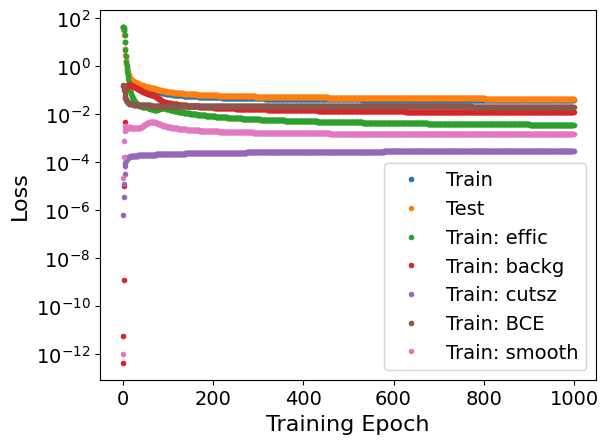

In [13]:
LCU.plotlosses(efficnet_losses,efficnet_losses_test)
plt.savefig('figures/loss_efficnet_dummy.pdf',bbox_inches='tight')

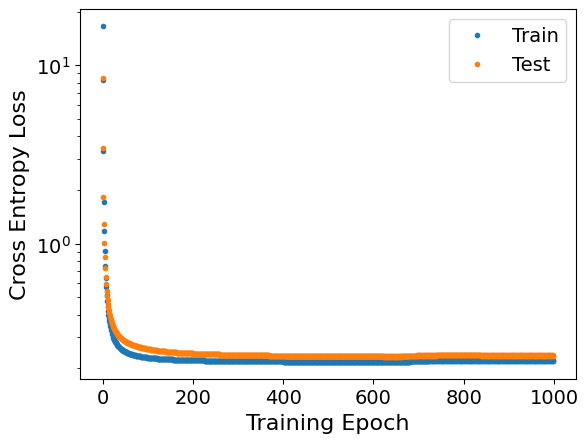

In [14]:
plt.plot(BCEnet_losses, '.', label="Train")
plt.plot(BCEnet_losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');
plt.savefig('figures/loss_BCEnet_dummy.pdf',bbox_inches='tight')

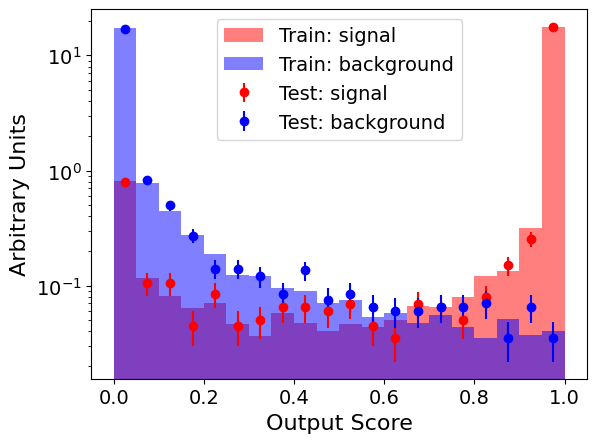

In [15]:
BCEnet.eval() # configure the model for evaluation (testing)
y_pred_test = BCEnet(x_test_tensor).detach().cpu()
y_pred_train= BCEnet(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("figures/scores_BCEnet_dummy.pdf",bbox_inches='tight')

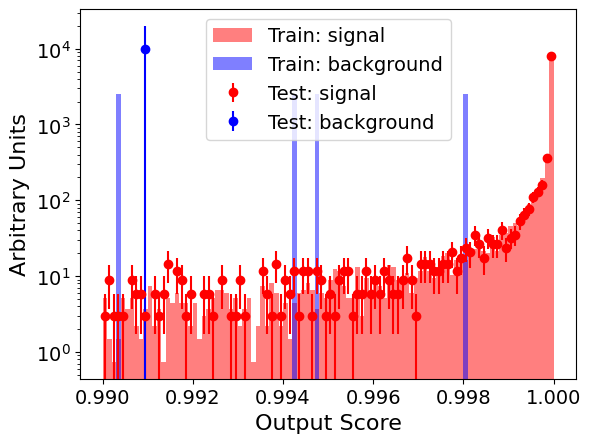

In [16]:
LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=100, range=(0.99,1))

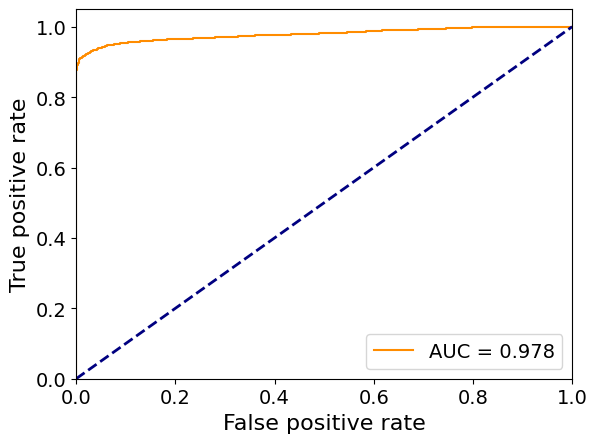

In [17]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("figures/ROC_BCEnet_dummy.pdf",bbox_inches='tight')

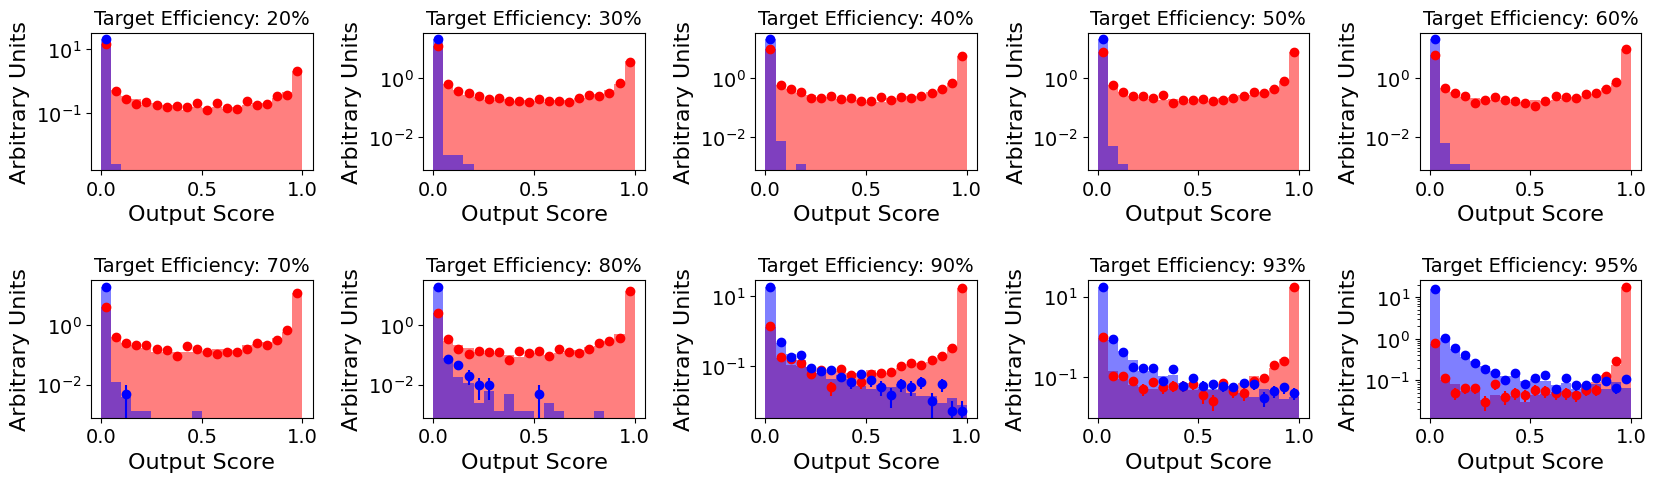

In [18]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
for n in range(len(targeteffics)):
    ax=fig.add_subplot(2,5,1+n)
    plt.subplots_adjust(hspace=0.8,wspace=0.5)
    plt.yscale('log')

    efficnet.nets[n].eval()
    y_pred_test = efficnet.nets[n](x_test_tensor).detach().cpu()
    y_pred_train= efficnet.nets[n](x_train_tensor).detach().cpu()

    LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test)
    plt.title(f"Target Efficiency: {int(efficnet.effics[n]*100):d}%")
    showlegend=False
    if not showlegend:
        plt.legend('',frameon=False)
    else:
        ylim=plt.gca().get_ylim()
        plt.ylim([1e-3, 10000*ylim[1]])


plt.savefig("figures/scores_efficscan_dummy.pdf",bbox_inches='tight')

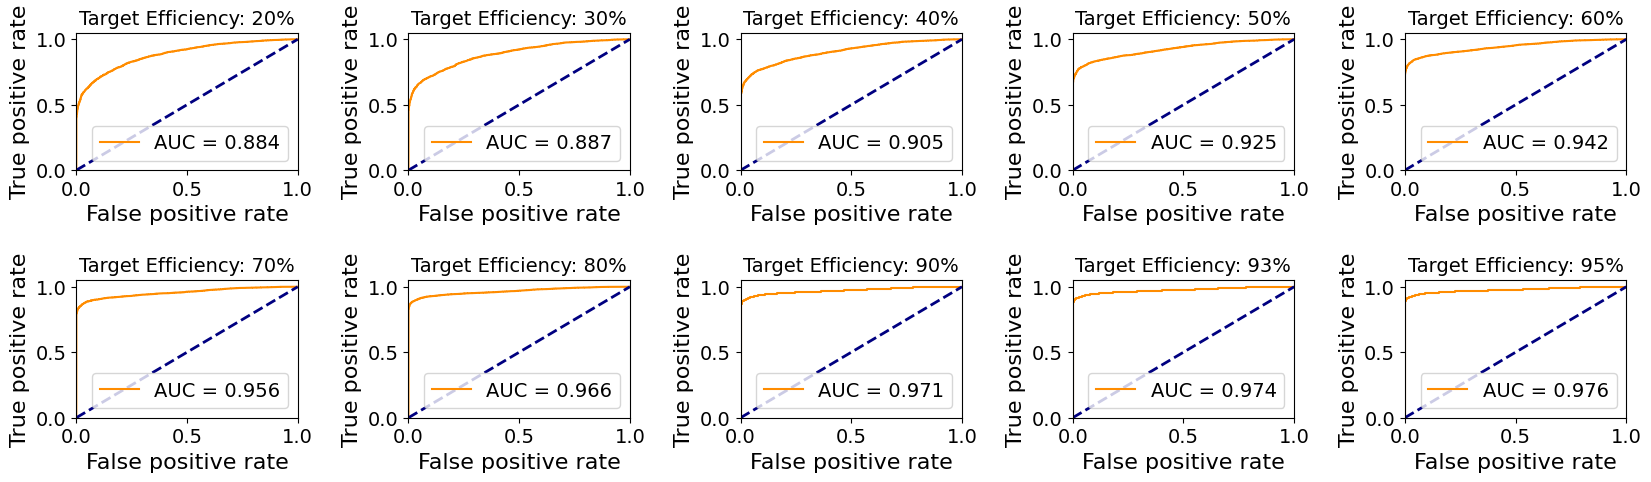

In [19]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
for n in range(len(targeteffics)):
    ax=fig.add_subplot(2,5,1+n)
    plt.subplots_adjust(hspace=0.8,wspace=0.5)

    efficnet.nets[n].eval()
    y_pred_test = efficnet.nets[n](x_test_tensor).detach().cpu()
    #y_pred_train= efficnet.nets[n](x_train_tensor).detach().cpu()

    LCU.make_ROC_curve(y_test, y_pred_test)
    plt.title(f"Target Efficiency: {int(efficnet.effics[n]*100):d}%")
    
plt.savefig("figures/ROC_efficscan_dummy.pdf",bbox_inches='tight')

Target efficiency: 20.0%
Signal     efficiency with net outputs: 20.6%
Background efficiency with net outputs:  0.00000%
BCE efficiency =  0.0, BCE background efficiency = 0.00000
Inspecting efficiency loss: alpha=10.0, target=0.200, subnet_effic=0.1980, subnet_backg=0.0000, efficloss=4.112e-05, backgloss=9.816e-07
------------
Target efficiency: 30.0%
Signal     efficiency with net outputs: 30.1%
Background efficiency with net outputs:  0.00000%
BCE efficiency = 25.1, BCE background efficiency = 0.00000
Inspecting efficiency loss: alpha=10.0, target=0.300, subnet_effic=0.2937, subnet_backg=0.0001, efficloss=4.021e-04, backgloss=7.031e-06
------------
Target efficiency: 40.0%
Signal     efficiency with net outputs: 39.9%
Background efficiency with net outputs:  0.00000%
BCE efficiency = 39.6, BCE background efficiency = 0.00000
Inspecting efficiency loss: alpha=10.0, target=0.400, subnet_effic=0.3937, subnet_backg=0.0001, efficloss=3.976e-04, backgloss=9.074e-06
------------
Target eff

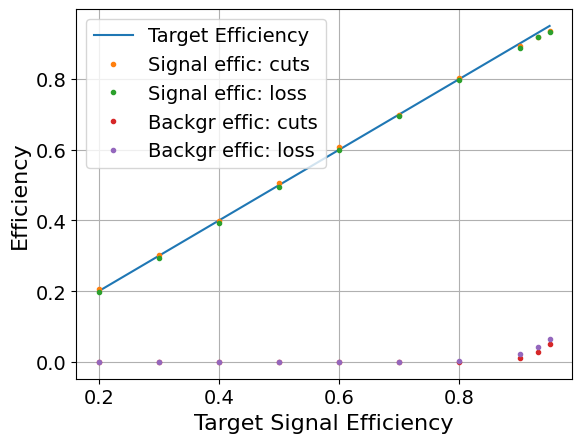

In [20]:
sig_effics=[]
bkg_effics=[]
loss_sig_effics=[]
loss_bkg_effics=[]

for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    sig_effic,bkg_effic=LCU.check_effic(x_test_tensor,y_test,efficnet.nets[n],True)
    sig_effics.append(sig_effic)
    bkg_effics.append(bkg_effic)
    
    # look at BCE network performance at similar efficiency
    y_pred_test = BCEnet(x_test_tensor).detach().cpu()
    fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
    for i in range(len(tpr)):
        if tpr[i]<targeteffics[n] and tpr[i+1]>targeteffics[n]:
            print(f"BCE efficiency = {tpr[i]*100:4.1f}, BCE background efficiency = {fpr[i]*100:6.5f}")
            break

    # check that after reloading the weights we still get the same performance after pretraining
    efficnet.nets[n].eval() # configure the model for evaluation (testing)
    y_pred_test = efficnet.nets[n](x_test_tensor)
    test_loss = loss_fn(y_pred_test, y_test_tensor, m, efficnet.nets[n], targeteffics[n], alpha, beta, gamma, delta, True)
    loss_sig_effics.append(test_loss.signaleffic.detach().numpy())
    loss_bkg_effics.append(test_loss.backgreffic.detach().numpy())
    print("------------")

plt.plot(targeteffics,targeteffics   , '-', label="Target Efficiency")
plt.plot(targeteffics,sig_effics     , '.', label="Signal effic: cuts")
plt.plot(targeteffics,loss_sig_effics, '.', label="Signal effic: loss")
plt.plot(targeteffics,bkg_effics     , '.', label="Backgr effic: cuts")
plt.plot(targeteffics,loss_bkg_effics, '.', label="Backgr effic: loss")
plt.legend()
plt.xlabel('Target Signal Efficiency')
plt.ylabel('Efficiency')
plt.grid()
plt.savefig("figures/efficiencies_efficscan_dummy.pdf",bbox_inches='tight')

I guess the message from this study is that scanning the output score distribution when optimizing using BCE loss
gives very similar performance to fixing an efficiency and optimizing for background rejection.  At a given efficiency,
the FPR for BCE loss is very similar to the FPR for the corresponding efficiency-tuned net, maybe a bit lower or higher, but overall consistent.

One could ask, then, why go through all the efficnet stuff?  The point is that scanning the output score, which is a single number per event, does not allow us to extract cuts for all variables from the previous network layer.

So I think the point is that we don't expect either to be better or worse, and the efficnet performance is not obviously worse than "just" using BCE, and allows us to extract cuts.

Another question we can ask: what cuts do we get from the BCE-trained net, and what efficiency do they correspond to?

In [21]:
effic_test,bg_effic_test = LCU.check_effic(x_test_tensor,y_test,BCEnet,False)
LCU.check_effic(x_test_tensor,y_test,BCEnet,True)

Signal     efficiency with net outputs: 92.9%
Background efficiency with net outputs:  3.21124%


(0.9289985052316891, 0.032112393376818864)

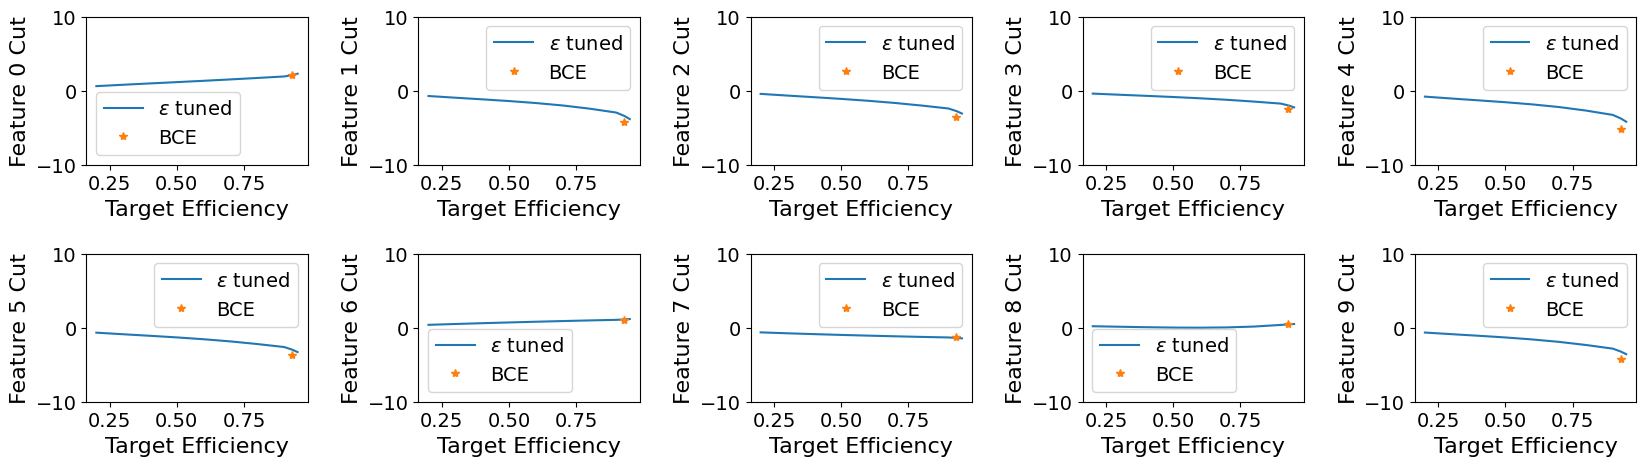

In [22]:
net=efficnet

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
targeteffics=net.effics
m=net.features

scaled_cuts=[len(targeteffics)*[0] for i in range(m)]
scaled_cuts_BCE=BCEnet.get_cuts().detach().numpy()
for n in range(len(targeteffics)):
    cuts=net.nets[n].get_cuts().detach().numpy()
    for f in range(m):
        cutval=cuts[f]
        scaled_cuts[f][n]=cutval
for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.6,wspace=0.5)
    ax.plot(targeteffics,scaled_cuts[b],label="$\\varepsilon$ tuned")
    ax.plot(effic_test,scaled_cuts_BCE[b],"*",label="BCE")
    ax.set_xlabel(f"Target Efficiency")
    ax.set_ylabel(f"Feature {b} Cut")
    #ax.set_title(f"Feature {b}")
    ax.set_ylim([-10,10])
    plt.legend()

plt.savefig("figures/cuts_efficscan_dummy.pdf",bbox_inches='tight')

There is generally excellent agreement here, which is great.

It's not clear why the scan of output scores for the BCE net does a better job at low efficiencies than the efficiency scan networks do...  maybe the training just happens faster for BCE, and the efficiency scan network needs more epochs to converge.  It's also possible that the training "gives up" when it hits the target signal efficiency and a sufficiently low background efficiency, so that it has little incentive to further improve.  Adding a BCE term to the loss function may help with this, or increasing the weight assigned to the background efficiency penalty.  But it also may not -- the structure of the network may be such that it may not be able to learn to push the background to low-enough values to make the ROC curve improve enough.

In fact: when requiring that the efficiency be low, the way the efficiency is calculated means that the final score must be low, as opposed to raising the threshold on the final score as we normally do.  So the network is being forced to learn to reject signal, in some sense, and this is qualitatively different from the BCE way of training, which just tries to get everything right.

Or maybe this set of inputs is just too easy.

To do: try training with some inputs that don't permit regions with S/B~infinity.

One test to do: compare the ROC curve for a fully-connected classification network with the ROC curve for the OneToOneLinear network.  Should be pretty similar with the dummy data since there is no correlation between input variables.

What does it mean that the BCE net learns biases that correspond to a super high signal efficiency?  Is it saying
that the separation between S and B is very good, such that the signal efficiency can be very high without accepting
much background?  Is the purity of some low-efficiency selections higher than it ever is for the BCE net, which has background with scores that appear to go all the way up to 1?  No, zooming in on the high-score region shows that there is a small range of BCE-trained scores with lots of signal events and very few background events.  So the BCE separation is definitely better.

Either way, probably good to:
* Plot the purity of the region
* Plot the significance (probably similar)

But the fact remains that the BCE performance seems to yield an optimal ROC curve.  

Given a set of cuts that reaches a target efficiency, is it optimal to relax one cut, or all of them?  I guess there's always one to relax first...  relaxing the cut changes the BCE and the gradient of the BCE wrt changes in that cut, such that relaxing that one or another one next may be more optimal.  that's what gradient descent should figure out.

After thinking more: this is a feature, not a bug.  The cuts we make corresponding to the 20% efficiency WP are in the middle of the signal distribution and the tail of the background distribution, so small changes in the inputs will neither significantly change the signal efficiency nor the background rejection.  By contrast, the 20% WP for the BCE-trained net corresponds to a cut at 0.999 or something, so small changes in the input features could have a big impact on the actual efficiency (signal or background).

The way to demonstrate this is probably to have some kind of uncertainty on the input values, and show that my net is robust to variations within that uncertainty, while the BCE net gives larger variations in signal efficiency and/or background rejection.  I think this will be a major benefit of this method.

In [23]:
BCEnet.weight

tensor([-1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.])

In [24]:
BCEnet.bias

Parameter containing:
tensor([2.1870, 4.1861, 3.5588, 2.4949, 5.1019, 3.6714, 1.0044, 1.2426, 0.4617,
        4.1730], requires_grad=True)

In [25]:
LCU.check_noisy_test_inputs(x_test_tensor, y_test_tensor, BCEnet, BCEnet.weight, 0.4, 0.2)

Output threshold for 40.0% efficiency: 0.9999994039535522 gives 39.6%

Signal efficiency for nominal, output>0.9999994039535522: 0.38066766317887396
Signal efficiency for noisy  , output>0.9999994039535522: 0.2862481315396114

Backgr efficiency for nominal, output>0.9999994039535522: 0.0
Backgr efficiency for noisy  , output>0.9999994039535522: 0.0

Output threshold for 40.0% efficiency if trained on noisy data: 0.9999969005584717 gives 39.8%


In [26]:
LCU.check_noisy_test_inputs(x_test_tensor, y_test_tensor, efficnet.nets[2], efficnet.nets[2].weight, 0.4, 0.2)

Output threshold for 40.0% efficiency: 0.9934355616569519 gives 17.6%

Signal efficiency for nominal, output>0.9934355616569519: 0.17513702042850024
Signal efficiency for noisy  , output>0.9934355616569519: 0.12506228201295466

Backgr efficiency for nominal, output>0.9934355616569519: 0.0
Backgr efficiency for noisy  , output>0.9934355616569519: 0.0

Output threshold for 40.0% efficiency if trained on noisy data: 0.9997366070747375 gives  5.0%


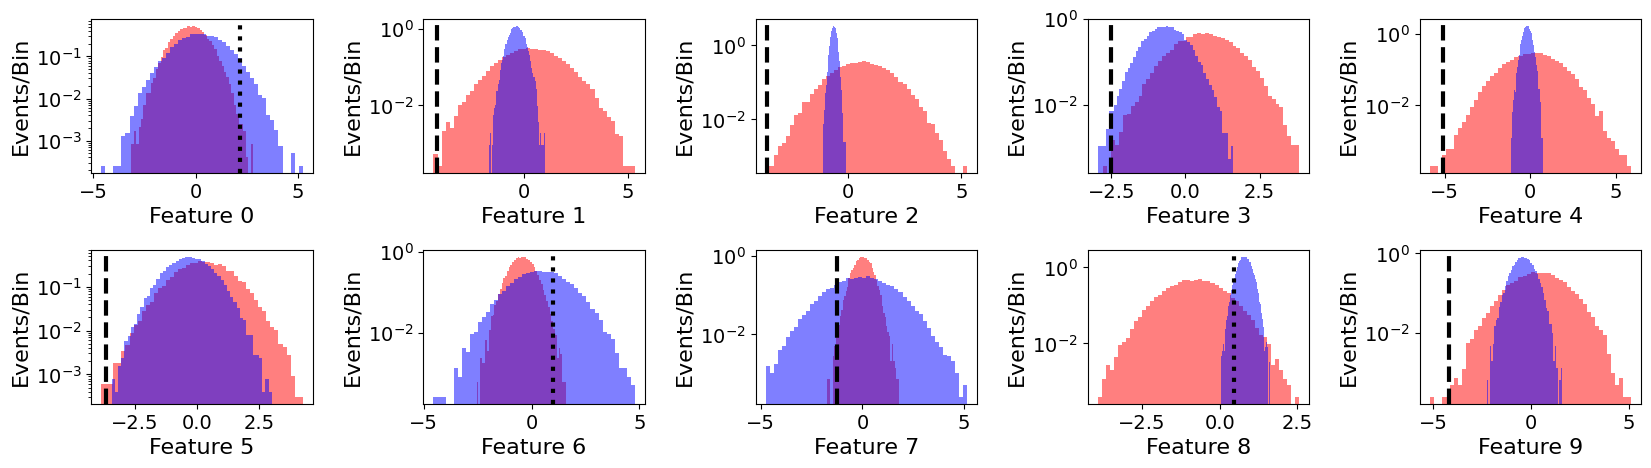

In [27]:
# Distributions after scaling for BCE-trained net:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

#biases=net.nets[n].bias.detach().numpy()
weights=BCEnet.weight.detach().numpy()
#scaled_cuts=-biases/weights
scaled_cuts=BCEnet.get_cuts().detach().numpy()

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], linestyle="dotted", color="black", lw=3) # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], linestyle="dashed", color="black", lw=3) # cut is "greater than"
plt.savefig("figures/featurescuts_BCEnet_dummy.pdf",bbox_inches='tight')

Looking at onenet:

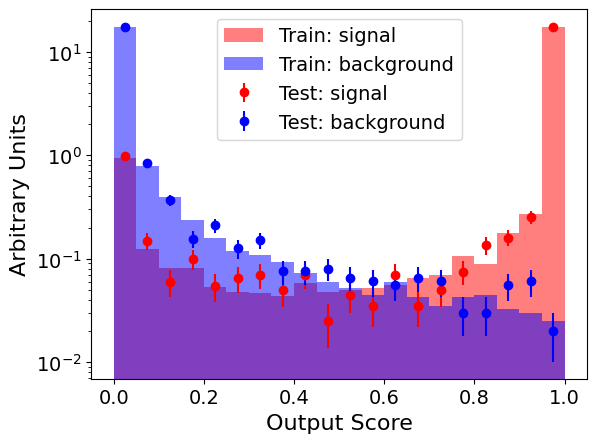

In [28]:
onenet.eval() # configure the model for evaluation (testing)
y_pred_test = onenet(x_test_tensor).detach().cpu()
y_pred_train= onenet(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("figures/scores_onenet_dummy_matchBCEeffic.pdf",bbox_inches='tight')

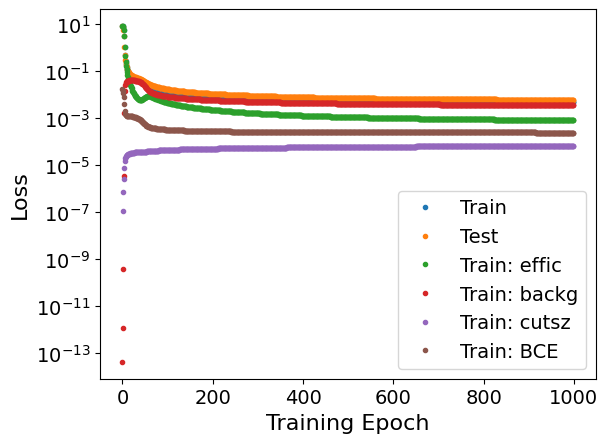

In [29]:
LCU.plotlosses(onenet_losses,onenet_losses_test)
plt.savefig("figures/loss_onenet_dummy.pdf",bbox_inches='tight')

In [30]:
effic_test,bg_effic_test = LCU.check_effic(x_test_tensor,y_test,onenet,False)
LCU.check_effic(x_test_tensor,y_test,onenet,True)

Signal     efficiency with net outputs: 91.9%
Background efficiency with net outputs:  2.70948%


(0.918784255107125, 0.027094831911690917)

In [31]:
loss_fn(y_pred_test, y_test_tensor, m, onenet, 0.93, alpha, beta, gamma, delta, True)

Inspecting efficiency loss: alpha=10.0, target=0.930, subnet_effic=0.9172, subnet_backg=0.0400, efficloss=1.631e-03, backgloss=3.998e-03


In [32]:
10*(0.93-0.9021)**2

0.00778410000000002

In [33]:
0.1*0.0883

0.008830000000000001

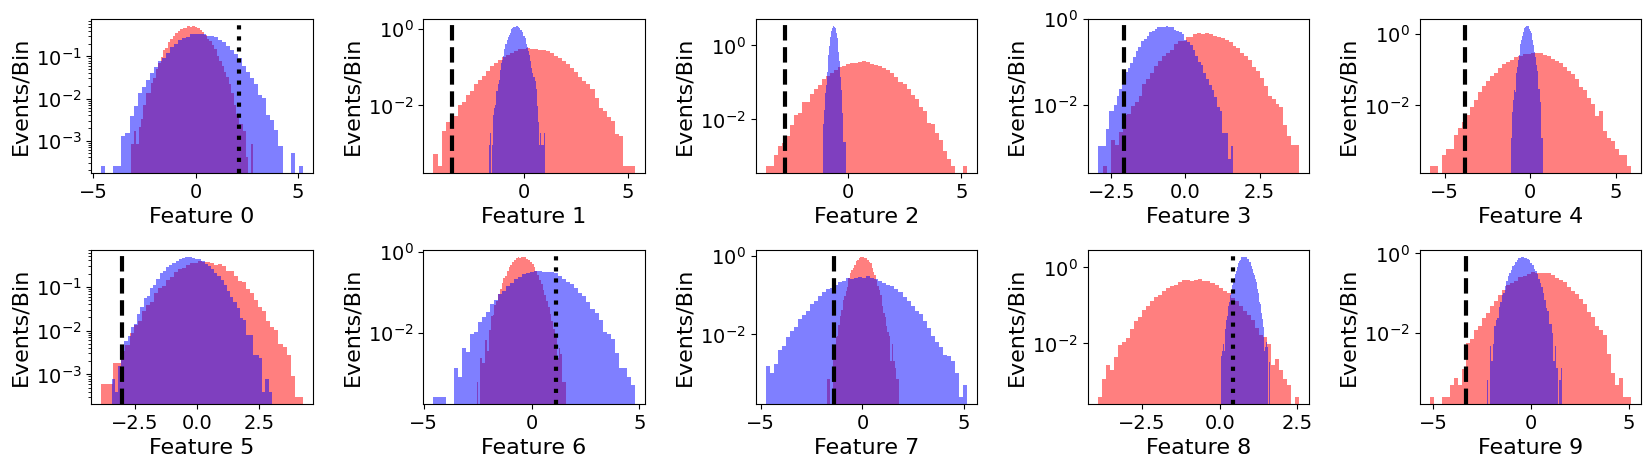

In [34]:
# Distributions after scaling for BCE-trained net:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

#biases=net.nets[n].bias.detach().numpy()
weights=onenet.weight.detach().numpy()
#scaled_cuts=-biases/weights
scaled_cuts=onenet.get_cuts().detach().numpy()

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], linestyle="dotted", color="black", lw=3) # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], linestyle="dashed", color="black", lw=3) # cut is "greater than"
plt.savefig("figures/featurescuts_onenet_dummy.pdf",bbox_inches='tight')

In [35]:
def get_scores_by_label(x_tensor, y_tensor, net):
    tp_scores=[]
    tn_scores=[]
    fp_scores=[]
    fn_scores=[]
    outputs = net.apply_cuts(x_tensor).detach().cpu()
    scores  = net(x_tensor).detach().cpu()
    m=outputs.shape[1]
    trues=torch.tensor(m*[True])
    for i in range(len(outputs)):
    
        tt=torch.zeros(m)
        t=torch.gt(outputs[i],tt)
    
        if torch.equal(t,trues) and y_tensor[i]==1.:
            tp_scores.append(scores[i])
        elif torch.equal(t,trues) and y_tensor[i]!=1.:
            fp_scores.append(scores[i])
        elif y_tensor[i]==1.:
            fn_scores.append(scores[i])
        elif y_tensor[i]!=1.:
            tn_scores.append(scores[i])

    return tp_scores, tn_scores, fp_scores, fn_scores

def plot_classifier_output_by_label(y_tp,y_fp,y_tn,y_fn, nbins=10, range=(0,1)):

    tp_hist=plt.hist(y_tp,nbins,density=True,range=range,histtype='stepfilled',alpha=0.5,color='red'   , label="True Signal: Pass")
    fn_hist=plt.hist(y_fn,nbins,density=True,range=range,histtype='stepfilled',alpha=0.5,color='yellow', label="True Signal: Fail")
    tn_hist=plt.hist(y_tn,nbins,density=True,range=range,histtype='stepfilled',alpha=0.5,color='blue'  , label="True Background: Fail")
    fp_hist=plt.hist(y_fp,nbins,density=True,range=range,histtype='stepfilled',alpha=0.5,color='green' , label="True Background: Pass")

    plt.yscale("log")
    plt.xlabel('Output Score')
    plt.ylabel('Arbitrary Units')
    plt.legend(loc="upper center")
    #plt.show()


/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


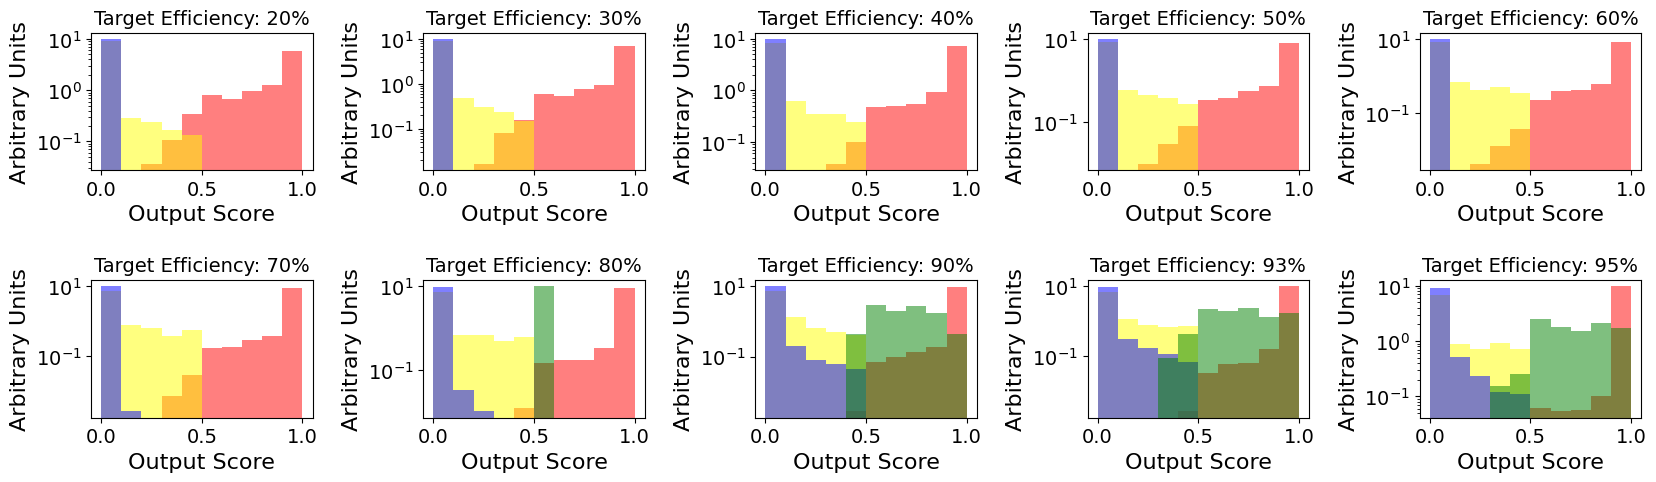

In [36]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
for n in range(len(targeteffics)):
    ax=fig.add_subplot(2,5,1+n)
    plt.subplots_adjust(hspace=0.8,wspace=0.5)
    plt.yscale('log')

    efficnet.nets[n].eval()
    tp,tn,fp,fn = get_scores_by_label(x_test_tensor,y_test_tensor,efficnet.nets[n])
    plot_classifier_output_by_label(tp,fp,tn,fn)
    
    plt.title(f"Target Efficiency: {int(efficnet.effics[n]*100):d}%")
    showlegend=False
    if not showlegend:
        plt.legend('',frameon=False)
    else:
        ylim=plt.gca().get_ylim()
        plt.ylim([1e-3, 10000*ylim[1]])


plt.savefig("figures/scoresbylabel_efficscan_dummy.pdf",bbox_inches='tight')

In [37]:
LCU.check_noisy_test_inputs(x_test_tensor, y_test_tensor, BCEnet, BCEnet.weight, 0.4, 0.0)

Output threshold for 40.0% efficiency: 0.9999994039535522 gives 39.6%

Signal efficiency for nominal, output>0.9999994039535522: 0.38066766317887396
Signal efficiency for noisy  , output>0.9999994039535522: 0.38066766317887396

Backgr efficiency for nominal, output>0.9999994039535522: 0.0
Backgr efficiency for noisy  , output>0.9999994039535522: 0.0

Output threshold for 40.0% efficiency if trained on noisy data: 0.9999994039535522 gives 39.6%


In [38]:
LCU.check_noisy_test_inputs(x_test_tensor, y_test_tensor, BCEnet, BCEnet.weight, 0.5, 0.0)

Output threshold for 50.0% efficiency: 0.9999969005584717 gives 49.9%

Signal efficiency for nominal, output>0.9999969005584717: 0.49551569506726456
Signal efficiency for noisy  , output>0.9999969005584717: 0.49551569506726456

Backgr efficiency for nominal, output>0.9999969005584717: 0.0
Backgr efficiency for noisy  , output>0.9999969005584717: 0.0

Output threshold for 50.0% efficiency if trained on noisy data: 0.9999969005584717 gives 49.9%


In [39]:
0.9999969-0.9999994039535522

-2.503953552279725e-06